In [2]:
# Necessary cells needed for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score,f1_score
from sklearn.preprocessing import LabelEncoder

Data Validation

This data has 1500 rows and 8 columns.I have validated all variables and made some changes wherever necesary.
All the columns are:
owned : numeric - 1 or not (0) - two possible outcomes,
make_model : character - 6 possible values,
review_month : character from Jan to Dec,
web_browser : character - 7 categories,
reviewer_age : Numeric - from 16 to so on ,
primary_use : Character - two categories,
value_for_money : rating from 1 to 10,
overall_rating : continuous values from  0 to 25

In [3]:

df=pd.read_csv("https://s3.amazonaws.com/talent-assets.datacamp.com/electric_bike_ratings_2212.csv")

df.head()

,owned,make_model,review_month,web_browser,reviewer_age,primary_use,value_for_money,overall_rating
0,1,Nielah-Eyden,Oct,Chrome,23,Commuting,5/10,18.62
1,0,Nielah-Keetra,Jun,NaN,24,Commuting,4/10,15.55
2,0,Lunna-Keetra,23-Oct,Chrome,28,Commuting,5/10,12.76
3,1,Hoang-Keetra,07-Nov,IE,41,Leisure,5/10,17.07
4,1,Lunna-Keetra,16-Sep,Chrome,33,Leisure,5/10,12.29


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   owned            1500 non-null   int64  
 1   make_model       1500 non-null   object 
 2   review_month     1500 non-null   object 
 3   web_browser      1350 non-null   object 
 4   reviewer_age     1500 non-null   object 
 5   primary_use      1500 non-null   object 
 6   value_for_money  1500 non-null   object 
 7   overall_rating   1500 non-null   float64
dtypes: float64(1), int64(1), object(6)
memory usage: 93.9+ KB


In [6]:
# Total number of missing values
df.isnull().sum()

owned                0
make_model           0
review_month         0
web_browser        150
reviewer_age         0
primary_use          0
value_for_money      0
overall_rating       0
dtype: int64

In [7]:
# validate two possible values
df['owned'].unique()

array([1, 0])

In [8]:
# validate 6 types of models
df['make_model'].nunique()

6

In [9]:
# validate month  from Jan to Dec
df['review_month'].unique()

array(['Oct', 'Jun', '23-Oct', '07-Nov', '16-Sep', '26-Aug', '01-Mar',
       '15-Mar', '09-Mar', 'Jul', '10-Nov', 'Mar', 'Apr', 'Sep', '27-Dec',
       '11-Nov', '07-Dec', 'Feb', 'Jan', '06-Jun', '12-Jul', '02-Aug',
       '23-Feb', '27-Jul', '26-Nov', '30-Apr', '31-Jul', '22-Nov',
       '05-Sep', '05-Dec', '21-Jul', '15-Nov', '07-Jun', '20-May',
       '23-Sep', '10-Sep', '19-Oct', '28-Oct', '08-Apr', '14-Feb',
       '28-Nov', '28-Feb', '28-Jul', '12-Apr', '25-Apr', '25-Oct',
       '08-Jul', '29-Mar', '22-Sep', '26-Jun', '24-May', '12-Mar',
       '15-Feb', '28-Aug', 'May', '16-Jun', '02-Jul', '06-Feb', '21-Jun',
       'Nov', '21-Apr', '19-Jul', '31-May', '11-Aug', '14-Mar', '12-Dec',
       '02-Apr', '23-Aug', '11-Feb', '24-Aug', '03-Jun', '01-Apr',
       '24-Nov', 'Dec', '26-Mar', '22-Oct', '22-Jan', '17-Mar', '05-Oct',
       '20-Mar', '13-Jul', '03-Oct', '16-Nov', '10-Apr', '12-Aug',
       '19-Aug', '09-Oct', 'Aug', '05-Nov', '23-Dec', '06-Jul', '03-Feb',
       '21-May', '

In [10]:
# validate 7 types of browser
df['web_browser'].unique()

array(['Chrome', nan, 'IE', 'Firefox', 'Safari', 'Android', 'Opera'],
      dtype=object)

In [11]:
# validate age from 16
df['reviewer_age'].unique()

array(['23', '24', '28', '41', '33', '47', '20', '32', '35', '22', '29',
       '39', '42', '36', '40', '27', '48', '34', '16', '21', '25', '30',
       '-', '46', '37', '31', '17', '44', '26', '38', '49', '50', '45',
       '19', '43', '18'], dtype=object)

In [12]:
# replace '-' variable to avg age in reviewer age column

# Calculate average age for non-null values in the column
avg_age = df.loc[df['reviewer_age'] != '-', 'reviewer_age'].astype(int).mean()

# Replace '-' with average age
df['reviewer_age'] = df['reviewer_age'].replace('-', avg_age)

# convert it back to int
df['reviewer_age'] = df['reviewer_age'].astype(int)                             

In [13]:
# validate two user reports
df['primary_use'].unique()

array(['Commuting', 'Leisure'], dtype=object)

In [12]:
# validate ratings from 1 to 10
df['value_for_money'].unique()

array(['5/10', '4/10', '3/10', '7/10', '6/10', '2/10', '9/10', '8/10',
       '10/10', '1/10'], dtype=object)

In [13]:
# validate total rating score from 0 to 25
df['overall_rating'].unique()


array([18.62, 15.55, 12.76, 17.07, 12.29, 15.28, 12.28, 15.92, 19.39,
       18.38, 19.26, 15.84, 19.25, 19.11, 19.23, 19.66, 20.38, 18.28,
       18.23, 12.33, 16.  , 12.93, 17.27, 18.83, 12.05, 15.2 , 18.86,
       15.14, 20.94, 14.73, 15.12, 19.06, 18.75, 16.25, 15.73, 20.2 ,
       18.51, 18.32, 17.93, 19.08, 17.24, 12.06, 16.93, 18.4 , 20.18,
       12.01, 14.8 , 18.77, 19.18, 20.33, 12.07, 15.13, 19.02, 18.31,
       18.64, 18.85, 18.61, 12.14, 18.14, 17.37, 22.76, 12.22, 15.83,
       21.33, 18.55, 16.59, 16.17, 12.5 , 15.06, 18.13, 14.79, 18.29,
       12.84, 13.18, 15.22, 19.13, 19.16, 12.17, 15.42, 16.97, 15.44,
       18.76, 15.26, 12.82, 15.38, 16.56, 17.13, 19.32, 16.98, 15.5 ,
       15.23, 20.29, 17.44, 18.74, 12.57, 17.42, 21.18, 15.85, 14.88,
       17.67, 14.71, 20.  , 15.51, 20.12, 18.93, 14.98, 18.88, 14.75,
       19.53, 14.81, 20.93, 18.7 , 18.34, 12.49, 12.83, 15.36, 19.97,
       15.47, 15.54, 20.16, 18.95, 20.96, 15.65, 18.42, 19.01, 15.63,
       11.97, 18.47,

In [14]:
# Replace the missing value with "unknown"
df['web_browser'].fillna("unknown",inplace = True)

In [15]:
# Check again if there is any missing value
df.isnull().sum()


owned              0
make_model         0
review_month       0
web_browser        0
reviewer_age       0
primary_use        0
value_for_money    0
overall_rating     0
dtype: int64

In [16]:
# validate any negative values in numeric variables
df.describe()

,owned,reviewer_age,overall_rating
count,1500.000000,1500.000000,1500.000000
mean,0.593333,32.556000,17.138907
std,0.491375,9.876769,2.445566
min,0.000000,16.000000,11.690000
25%,0.000000,24.000000,15.320000
50%,1.000000,32.000000,18.240000
75%,1.000000,41.000000,18.840000
max,1.000000,50.000000,22.760000


Exploratory analysis

Target Variable - owned

Since,the product team wants to extend the survey. But, they want to be sure they can predict whether the ratings came from owners or non-owners.
we use a  barplot visualization to show the number of reviews from owners and non-owners: 
a->From the visualization, it is clear that the category of the variable "owned" with value 1 (or owners) has the most number of observations.
b->The observations are not balanced across categories of the variable "owned". The number of observations for owners is more than non-owners.

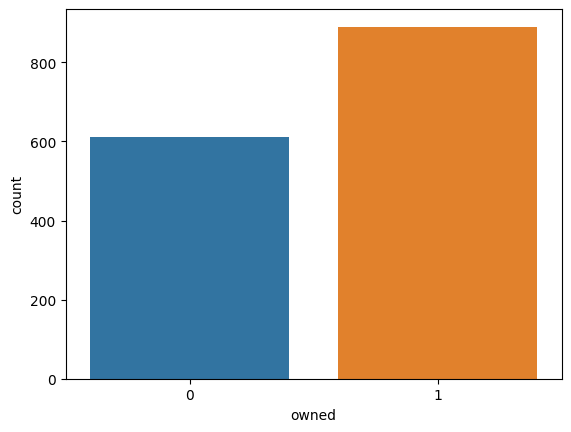

In [17]:
sns.countplot(x='owned', data=df)
plt.show()

Looking the histplot below, we can see most of the higher ratings are between 18 to 20.

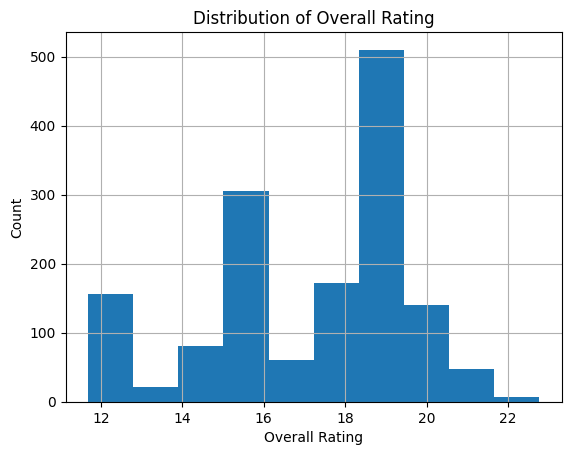

In [18]:
# For distribution of overall rating, we use histogram visualization

df['overall_rating'].hist()
plt.xlabel('Overall Rating')
plt.ylabel('Count')
plt.title('Distribution of Overall Rating')
plt.show()


By looking at below, ownership has higher overallrating than the non ownership.
And same goes in web browser and  in primary use,Most of the rater are owner.

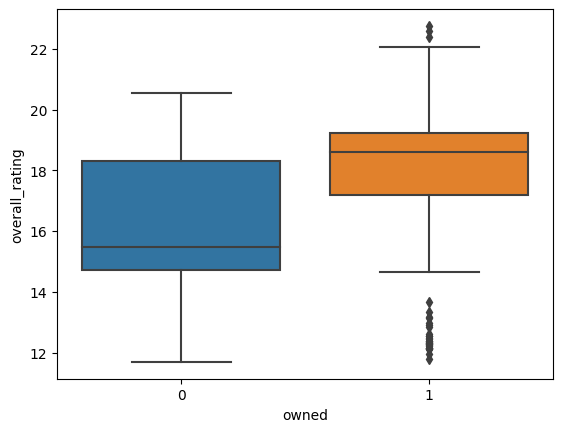

In [19]:
# We use a boxplot visualization to show the relationship between ownership and overall rating:

sns.boxplot(x='owned', y='overall_rating', data=df)
plt.show()


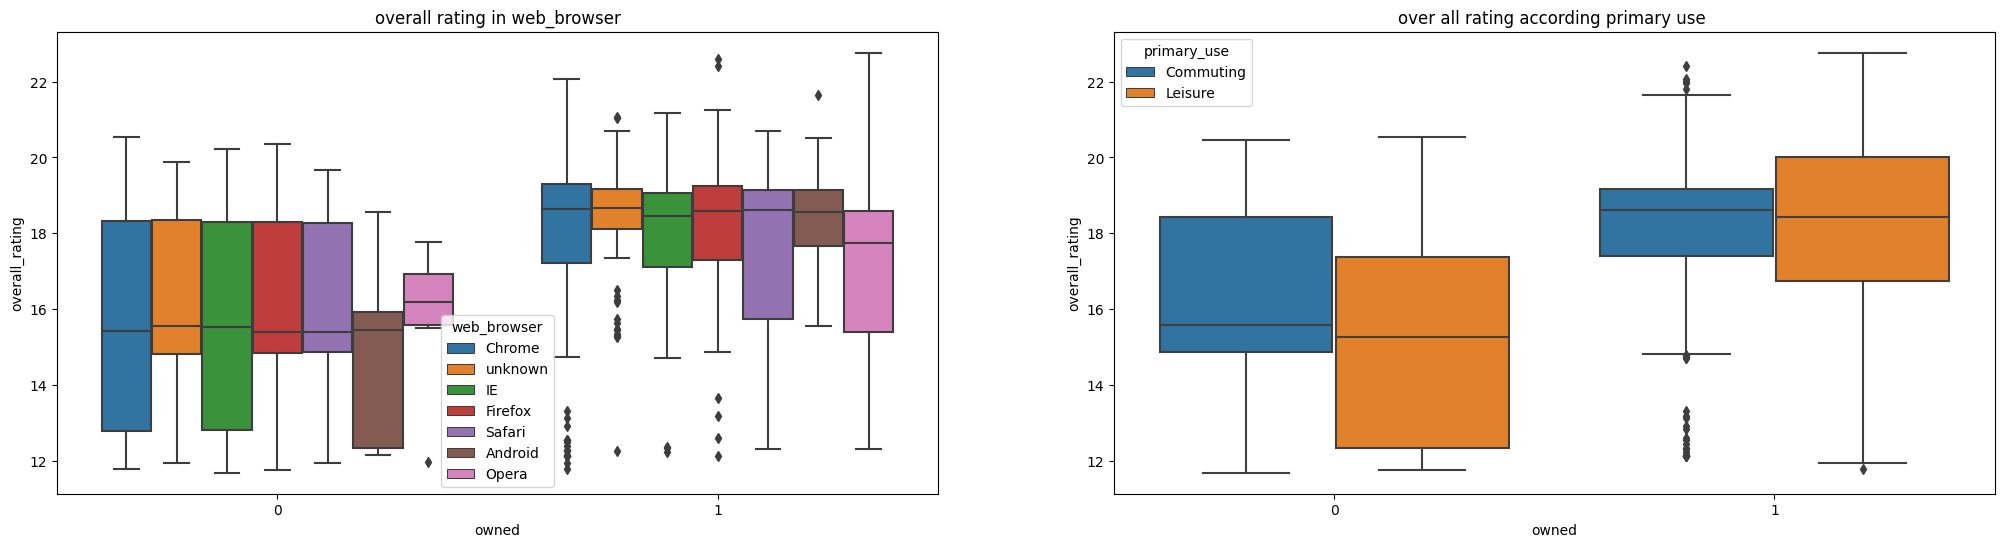

In [20]:
# realtionship between ownership and overall rating in websites and acoording to primary uses

fig, axes = plt.subplots(1,2,figsize=(25,6))

sns.boxplot(x='owned', y='overall_rating',hue ='web_browser',data = df,ax=axes[0]).set(title='overall rating in web_browser')
sns.boxplot(x ='owned',y ='overall_rating',data =df,hue='primary_use',ax=axes[1]).set(title='over all rating according primary use ')
plt.show()

Model Fitting

The business wants to predict whether a review came from an owner or not using the data provided and it is classification tasks
so i will use Logistic Regression, it is easy to train and fast to predict and it gives an estimate of the probability of the target variable for each input.
For the comparison model i will use Random Forest Classifier ,It can handle missing data and categorical variables, and it is robust to outliers and noisy data. It also gives an estimate of the importance of each feature, which is useful for understanding the dataset.


Prepare Data for Modelling

To enable modelling, we chose make_model, review_month,web_browser,reviewer_age,primary_use, value_for_money as features, owned as target variables.
I also have made the following changes:

Convert the categorical variables into numeric features and
Split the data into a training set and a test set

In [27]:
# Split dataset into 80% training set and 20% test set
X = df[['make_model', 'review_month', 'web_browser', 'reviewer_age', 'primary_use',
        'value_for_money']]
y = df['owned']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:
# converting into numerical variable
encoder = LabelEncoder()
df['make_model'] = encoder.fit_transform(df['make_model'])
df['review_month'] = encoder.fit_transform(df['review_month'])
df['web_browser'] = encoder.fit_transform(df['web_browser'])
df['primary_use'] = encoder.fit_transform(df['primary_use'])
df['value_for_money'] = encoder.fit_transform(df['value_for_money'])


Logistic Regeression

In [29]:
log_reg = LogisticRegression( C = 0.1 , penalty = 'l2')
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
# Calculate the f1_score
f1 = f1_score(y_test, y_pred_log_reg)
print("F1 Score:", f1)
# Calculate the precision_score
precision = precision_score(y_test, y_pred_log_reg)
print("Precision Score:", precision) 

F1 Score: 0.7650000000000001
Precision Score: 0.7149532710280374


Finding the feature importance

In [30]:
# Train the logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Get the feature importances
coefs = log_reg.coef_[0]

# Create a list of feature names
feature_names = X.columns

# Create a dataframe of feature importances
feature_importances = pd.DataFrame({'feature': feature_names, 'coef': coefs})

# Sort the dataframe by feature importance
feature_importances.sort_values(by='coef', ascending=False, inplace=True)

# Print the feature importances
print(feature_importances)


           feature      coef
5  value_for_money  0.560027
3     reviewer_age  0.005705
1     review_month -0.001034
0       make_model -0.041582
2      web_browser -0.087920
4      primary_use -0.458329


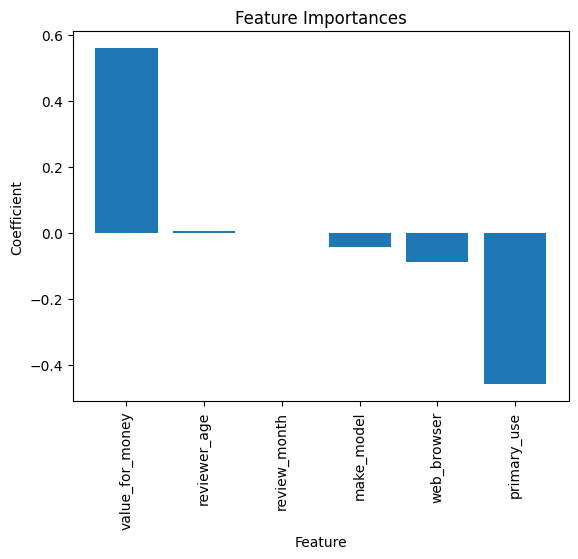

In [54]:
# Plot the feature importances
plt.bar(feature_importances['feature'], feature_importances['coef'])
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Feature Importances')
plt.xticks(rotation=90)
plt.show()

Finding the best parameters

In [55]:
# Define the parameter grid
param_grid = {'C': [0.1, 1, 10],
              'penalty': ['l1', 'l2']}

# Create the grid search object
grid_search = GridSearchCV(log_reg, param_grid, cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


Best parameters:  {'C': 0.1, 'penalty': 'l2'}
Best score:  0.6625


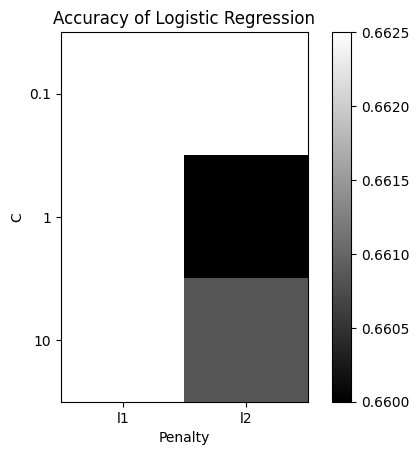

In [56]:
# visulizing it 
# Get the results of the grid search
results = grid_search.cv_results_

# Extract the mean test score for each combination of parameters
scores = results['mean_test_score'].reshape(len(param_grid['C']), len(param_grid['penalty']))

# Create a heatmap of the test scores
plt.imshow(scores, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.xlabel('Penalty')
plt.ylabel('C')
plt.xticks(np.arange(len(param_grid['penalty'])), param_grid['penalty'])
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'])
plt.title('Accuracy of Logistic Regression')
plt.show()

Random Forest Classifier

In [36]:

rnd_clf = RandomForestClassifier(n_estimators = 200 , max_depth = 5)
rnd_clf.fit(X_train, y_train)

y_pred_rnd_clf = rnd_clf.predict(X_test)

f1 = f1_score(y_test, y_pred_rnd_clf)
print("F1 Score:", f1)
# Calculate the precision_score
precision = precision_score(y_test, y_pred_rnd_clf)
print("Precision Score:", precision) 

F1 Score: 0.7989949748743718
Precision Score: 0.75


Finding the feature importance

In [37]:
# Train the random forest classifier
rnd_clf = RandomForestClassifier()
rnd_clf.fit(X_train, y_train)

# Get the feature importances
importances = rnd_clf.feature_importances_

# Create a list of feature names
feature_names = X.columns

# Create a dataframe of feature importances
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort the dataframe by feature importance
feature_importances.sort_values(by='importance', ascending=False, inplace=True)

# Print the feature importances
print(feature_importances)

           feature  importance
1     review_month    0.265154
3     reviewer_age    0.236237
0       make_model    0.202219
5  value_for_money    0.177564
2      web_browser    0.092300
4      primary_use    0.026526


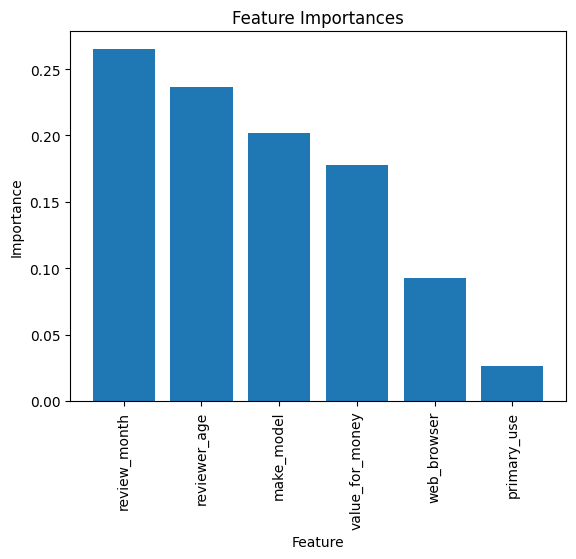

In [38]:
# Plot the feature importances
plt.bar(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)
plt.show()

Finding the best parameter

In [40]:
# Define the parameter grid
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [5, 10, 15] }

# Create the grid search object
grid_search = GridSearchCV(rnd_clf, param_grid, cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


Best parameters:  {'max_depth': 5, 'n_estimators': 200}
Best score:  0.7241666666666667


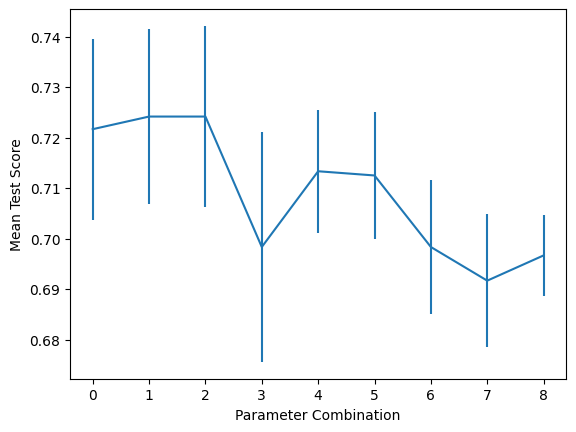

In [41]:
# visulizing it

# Extract the results of the grid search
results = grid_search.cv_results_

# Extract the mean test scores
mean_test_scores = results['mean_test_score']

# Extract the standard deviation of the test scores
std_test_scores = results['std_test_score']

# Extract the parameters that were tested
params = results['params']

# Plot the mean test scores
plt.errorbar(range(len(params)), mean_test_scores, yerr=std_test_scores)
plt.xlabel('Parameter Combination')
plt.ylabel('Mean Test Score')
plt.show()


This above  plot  shows the mean test score for each parameter combination tested in the grid search, along with the standard deviation of the test scores. The x-axis shows the index of the parameter combination, and the y-axis shows the mean test score.

why i choose them to be my evaluation?

the precision_score metric  focus on the model's ability to correctly predict the positive class, specifically minimizing the number of false positives.
It ranges between 0 and 1, where 1 represents a perfect score and 0 represents a poor score.Precision is a measure of how many of the positive predictions were actually correct.

f1_score metric balance precision and recall and get a single number that
represents the overall performance of the model.
It ranges between 0 and 1, where 1 represents a perfect score and 0 represents a poor score.
 F1 score is a better measure than accuracy, especially if you have 
 an uneven class distribution.

The f1_score of the Logistic Regression model and Decision Tree model is  0.76 and 0.80, meaning that Random Forest Classification model predicts more correctly than Logistic Regression 
And Precision_score of Logistic Regression and Random Forest Classification is 0.71 and 0.75,meaning that Random Forest Classification is considered better performing model.

From this metric, we can conclude that the Random Forest classification  model has a higher chance of performing better.